## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/AA 2024-2025/DA drive/AN2DL/Homework

Mounted at /gdrive
/gdrive/My Drive/AA 2024-2025/DA drive/AN2DL/Homework


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Set the global policy for mixed precision (16/32-bit float)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [ ]:
# Load the training data
data = np.load('filtered_data.npz')
X = data['images']
y = data['labels']

In [ ]:
# Divide train, val and test sets
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (9567, 96, 96, 3)
Training-Validation Label Shape: (9567, 1)
Test Data Shape: (2392, 96, 96, 3)
Test Label Shape: (2392, 1)


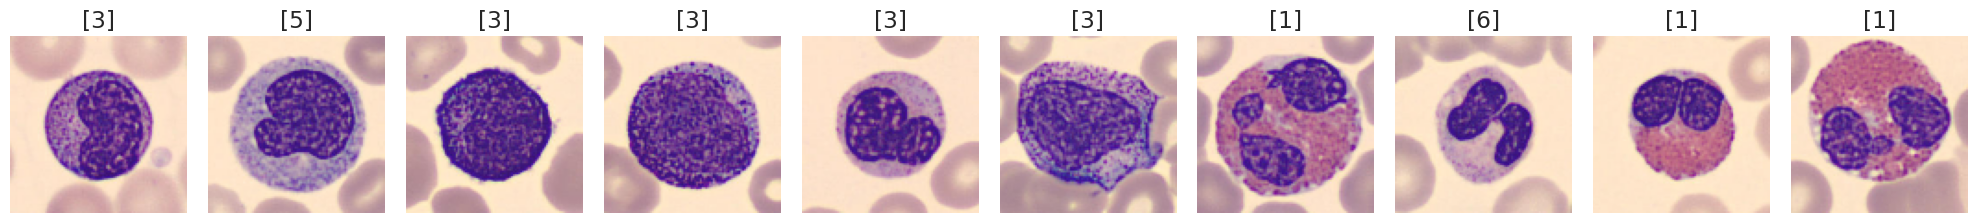

In [ ]:
# Display a sample of images from the training-validation dataset
num_img = 10
random.seed(10)
random_indices = random.sample(range(len(X_train_val)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_train_val[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{y_train_val[idx]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
6    1850
1    1759
3    1653
7    1302
2     866
5     789
0     675
4     673
Name: count, dtype: int64


In [ ]:
# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

from tensorflow.keras.utils import to_categorical

# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Numero di classi nel dataset
num_classes = len(np.unique(y_train_val))  # Ad esempio, 8 classi

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (8610, 96, 96, 3)
Training Label Shape: (8610, 8)
Validation Data Shape: (957, 96, 96, 3)
Validation Label Shape: (957, 8)


## 🛠️ Train and Save the Model

In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
# Number of training epochs
epochs = 500

# Batch size for training
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 1e-4

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 500
Batch Size: 64
Learning Rare: 0.0001


In [ ]:
# Initialise MobileNetV3Small model with pretrained weights, for transfer learning
net = tfk.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling='max',
    name="inception_resnet_v2",
)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze all layers in EfficientNetB0 to use it solely as a feature extractor
net.trainable = False

# Apply data augmentation for training robustness
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
], name='preprocessing')

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl, models as tfk, losses, optimizers, initializers, regularizers
from tensorflow.keras.layers import Resizing

def build_model(
    input_shape,
    output_shape,
    learning_rate,
    seed,
    augmentation=None, # Add augmentation as an optional parameter
    l2_lambda=5e-4
):
    tf.random.set_seed(seed)

    # Define the input layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    # Apply augmentation if provided (use a dictionary format for MixUp)
    if augmentation:
        x = augmentation(inputs)
    else:
        x = inputs

    # Weight initialization and regularization
    initializer = initializers.HeNormal(seed=seed)
    regularizer = regularizers.l2(l2_lambda)

    # preprocessing of inputs
    x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)

    # Pass augmented inputs through the network feature extractor
    x = net(x)

    # Fully Connected Layers
    x = tfkl.Dense(16, kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(0.5, seed=seed)(x)

    # Output Layer
    outputs = tfkl.Dense(output_shape, kernel_initializer=initializer, kernel_regularizer=regularizer, activation='softmax', dtype='float32', name='output')(x)

    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Corrected loss and optimizer imports
    loss = losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam()
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [ ]:
# Build the model with specified input and output shapes
model = build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate, seed=seed, augmentation=augmentation)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture with the correct import
# plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ cast_1 (Cast)                       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip (RandomFlip)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation                │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_zoom (RandomZoom)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ true_divide (TrueDivide)            │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ subtract (Subtract)                 │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ inception_resnet_v2 (Functional)    │ (None, 1536)                 │    54,336,736 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv2d (Conv2D)                │ (None, 47, 47, 32)           │           864 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ batch_normalization            │ (None, 47, 47, 32)           │            96 │    N    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ activation (Activation)        │ (None, 47, 47, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv2d_1 (Conv2D)              │ (None, 45, 45, 32)           │         9,216 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ batch_normalization_1          │ (None, 45, 45, 32)           │            96 │    N    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ activation_1 (Activation)      │ (None, 45, 45, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv2d_2 (Conv2D

 Total params: 54,361,528 (207.37 MB)

 Trainable params: 24,760 (96.72 KB)

 Non-trainable params: 54,336,768 (207.28 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping directly

# Define the patience value for early stopping
patience = 10

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'NoPainNoTrain'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 44s 123ms/step - accuracy: 0.3226 - loss: 1.9193 - val_accuracy: 0.7283 - val_loss: 0.9835
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - accuracy: 0.5759 - loss: 1.2640 - val_accuracy: 0.7565 - val_loss: 0.8050
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6209 - loss: 1.1205 - val_accuracy: 0.7983 - val_loss: 0.6884
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6312 - loss: 1.0570 - val_accuracy: 0.8025 - val_loss: 0.6430
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.6405 - loss: 1.0300 - val_accuracy: 0.8109 - val_loss: 0.5830
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.6416 - loss: 1.0076 - val_accuracy: 0.8203 - val_loss: 0.5677
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6555 - loss: 0.9548 - val_accuracy: 0.8234 - val_loss: 0.5366
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.6654 - loss: 0.

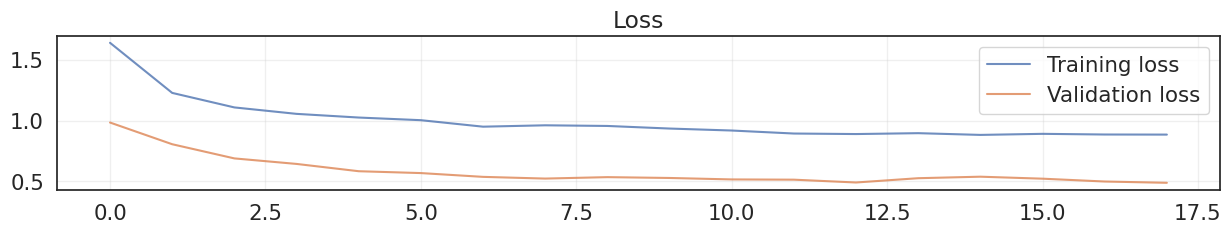

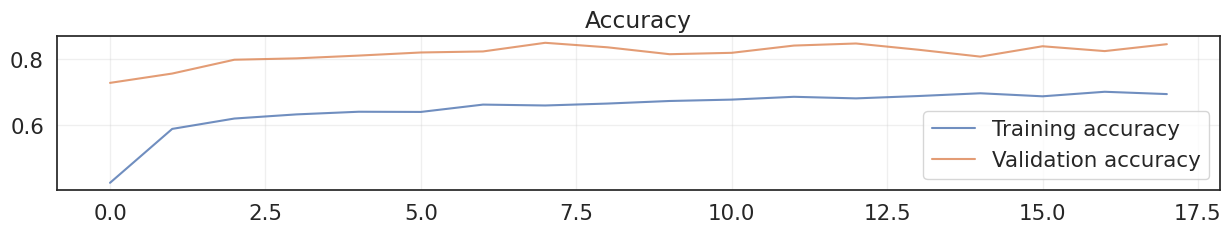

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
print(model_filename)

NoPainNoTrain84.95.keras


In [ ]:
# Re-load the model after transfer learning
ft_model = tf.keras.models.load_model('NoPainNoTrain84.95.keras')

# Display a summary of the model architecture
# ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Set all EfficientNetB0 layers as non-trainable
for layer in ft_model.get_layer('inception_resnet_v2').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('inception_resnet_v2').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

1 conv2d Conv2D True
4 conv2d_1 Conv2D True
7 conv2d_2 Conv2D True
11 conv2d_3 Conv2D True
14 conv2d_4 Conv2D True
18 conv2d_8 Conv2D True
21 conv2d_6 Conv2D True
22 conv2d_9 Conv2D True
28 conv2d_5 Conv2D True
29 conv2d_7 Conv2D True
30 conv2d_10 Conv2D True
31 conv2d_11 Conv2D True
41 conv2d_15 Conv2D True
44 conv2d_13 Conv2D True
45 conv2d_16 Conv2D True
50 conv2d_12 Conv2D True
51 conv2d_14 Conv2D True
52 conv2d_17 Conv2D True
60 block35_1_conv Conv2D True
63 conv2d_21 Conv2D True
66 conv2d_19 Conv2D True
67 conv2d_22 Conv2D True
72 conv2d_18 Conv2D True
73 conv2d_20 Conv2D True
74 conv2d_23 Conv2D True
82 block35_2_conv Conv2D True
85 conv2d_27 Conv2D True
88 conv2d_25 Conv2D True
89 conv2d_28 Conv2D True
94 conv2d_24 Conv2D True
95 conv2d_26 Conv2D True
96 conv2d_29 Conv2D True
104 block35_3_conv Conv2D True
107 conv2d_33 Conv2D True
110 conv2d_31 Conv2D True
111 conv2d_34 Conv2D True
116 conv2d_30 Conv2D True
117 conv2d_32 Conv2D True
118 conv2d_35 Conv2D True
126 block35_4_conv

In [ ]:
# Set the number of layers to freeze

# Calcola i parametri totali
trainable_params = sum(
    tf.reduce_sum([tf.size(var) for var in layer.trainable_weights]).numpy()
    for layer in ft_model.get_layer('inception_resnet_v2').layers
)
target_params = 0.99 * trainable_params  # Il 1% dei parametri totali

# Trova N
cumulative_params = 0
N = 0
for i, layer in enumerate(ft_model.get_layer('inception_resnet_v2').layers):
    cumulative_params += sum(tf.size(var).numpy() for var in layer.trainable_weights)
    if cumulative_params >= target_params:
        N = i
        break

print(N)

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('inception_resnet_v2').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('inception_resnet_v2').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True, show_trainable=True)

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

777
0 input_layer False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed_5b False
41 conv2d_15 False
42 batch_normalizatio

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ cast_3 (Cast)                       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip (RandomFlip)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation                │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_zoom (RandomZoom)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ true_divide (TrueDivide)            │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ subtract (Subtract)                 │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ inception_resnet_v2 (Functional)    │ (None, 1536)                 │    54,336,736 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv2d (Conv2D)                │ (None, 47, 47, 32)           │           864 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ batch_normalization            │ (None, 47, 47, 32)           │            96 │    N    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ activation (Activation)        │ (None, 47, 47, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv2d_1 (Conv2D)              │ (None, 45, 45, 32)           │         9,216 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ batch_normalization_1          │ (None, 45, 45, 32)           │            96 │    N    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ activation_1 (Activation)      │ (None, 45, 45, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv2d_2 (Conv2D

 Total params: 54,411,054 (207.56 MB)

 Trainable params: 3,219,640 (12.28 MB)

 Non-trainable params: 51,141,888 (195.09 MB)

 Optimizer params: 49,526 (193.47 KB)

In [ ]:
# Compile the model
loss = losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
metrics = ['accuracy']
ft_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'NoPainNoTrainFT'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - accuracy: 0.6192 - loss: 1.0867 - val_accuracy: 0.8265 - val_loss: 0.5620
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7122 - loss: 0.8376 - val_accuracy: 0.8621 - val_loss: 0.4590
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7195 - loss: 0.8127 - val_accuracy: 0.8725 - val_loss: 0.4305
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7456 - loss: 0.7351 - val_accuracy: 0.8809 - val_loss: 0.4219
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.7482 - loss: 0.7344 - val_accuracy: 0.8704 - val_loss: 0.4245
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7545 - loss: 0.7142 - val_accuracy: 0.8715 - val_loss: 0.4348
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7686 - loss: 0.6818 - val_accuracy: 0.8903 - val_loss: 0.3612
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7676 - loss: 0.6858

In [ ]:
print(model_filename)

NoPainNoTrainFT91.64.keras


In [ ]:
# Load the saved model
model = tf.keras.models.load_model('NoPainNoTrainFT91.64.keras')

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

In [ ]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=y, yticklabels=y, cmap='Blues')
# plt.xlabel('True labels')
# plt.ylabel('Predicted labels')
# plt.show()

Accuracy score over the test set: 0.9139
Precision score over the test set: 0.9176
Recall score over the test set: 0.9139
F1 score over the test set: 0.9143


## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('NoPainNoTrainFT91.64.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py NoPainNoTrainFT91.64.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 55%)
  adding: NoPainNoTrainFT91.85.keras (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>